In [1]:
import os
import glob
import pandas as pd

from utils import TextPreprocessor

from pprint import pprint
from collections import Counter
from wordcloud import WordCloud

import gensim
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models
import gensim.corpora as corpora

[nltk_data] Downloading package omw-1.4 to /home/uzair/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/uzair/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/uzair/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Path config

In [2]:
data_path = os.path.join(os.getcwd() , 'data')
lda_results_path = os.path.join(os.getcwd() , 'lda_results')

In [3]:
data_path

'/home/uzair/github/news-data-analysis/data'

# Reading csvs

In [4]:
data = [pd.read_csv(csv) for csv in glob.glob(os.path.join(data_path, '*csv'))]

In [5]:
data  = pd.concat(data, axis=0)

In [6]:
data

,title,text,published_date
0,Business Beat: A look back at some of the Long...,Jo Lee Ferguson wishes she kept her maiden nam...,None
1,Oceanside Economic News: 2021 Business Opening...,Business Oceanside Economic News: 2021 Busines...,2022-01-02 00:39:58+00:00
2,US companies are thriving despite the pandemic...,Nearly two years after the coronavirus pandemi...,None
3,16-year-old student athlete starts small business,16-year-old student athlete starts small busin...,2022-01-01 22:09:00+00:00
4,To make your financial New Year's resolutions ...,MilosStankovic | E+ | Getty Images\n\nPeople h...,2022-01-01 00:00:00
...,...,...,...
28276,Just in time for summer: 2 Vancouver beaches c...,With hot weather on the way this weekend for t...,2022-06-24 18:36:00-04:00
28277,Travel therapy: Vacations can benefit people w...,"JOONDALUP, Australia — Ever feel like heading ...",2022-06-24 17:18:02+00:00
28278,"The healthiest communities in America, accordi...","For the third year in a row, Los Alamos County...",2022-06-24 00:00:00
28279,Thinking about buying stock in Blue Hat Intera...,"NEW YORK, June 24, 2022 /PRNewswire/ -- Invest...",None


# Considering only title for analysis

In [7]:
data.drop(['text', 'published_date'], axis=1, inplace=True)

# Text preprocessing

In [8]:
text_prepocessor = TextPreprocessor(
    stopwords=True,
    stemming=False,
    lemmatization=True,
    html_tags=True,
    urls=True,
    punctuation=True,
    digits=True,
    max_word_lenth=5
)

In [9]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

In [10]:
data['preocessed'] = data['title'].apply(text_prepocessor.preprocess)

In [11]:
data['preocessed']

0                               business longview business
1        oceanside economic business opening notable pr...
2                        company thriving despite pandemic
3                     student athlete start small business
4                               financial resolution stick
                               ...                        
28262                                     courage campaign
28263                           record covid related death
28268                                      abortion canada
28276               summer vancouver beach closed swimming
28279    thinking buying stock interactive vroom revlon...
Name: preocessed, Length: 78625, dtype: object

# Analysing data

In [12]:
data_wrods = data['preocessed'].str.split()
all_text_tokens = " ".join(data['preocessed']).split()

In [13]:
word_freq = Counter(all_text_tokens).most_common(25)
word_freq_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])
word_freq_df

,Word,Frequency
0,health,6437
1,covid,3977
2,world,3599
3,nation,3479
4,business,3237
5,technology,2997
6,sport,2577
7,first,2079
8,ukraine,1692
9,national,1488


/home/uzair/miniconda3/envs/news-analysis/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/uzair/miniconda3/envs/news-analysis/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/uzair/miniconda3/envs/news-analysis/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/uzair/miniconda3/envs/news-analysis/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be remove

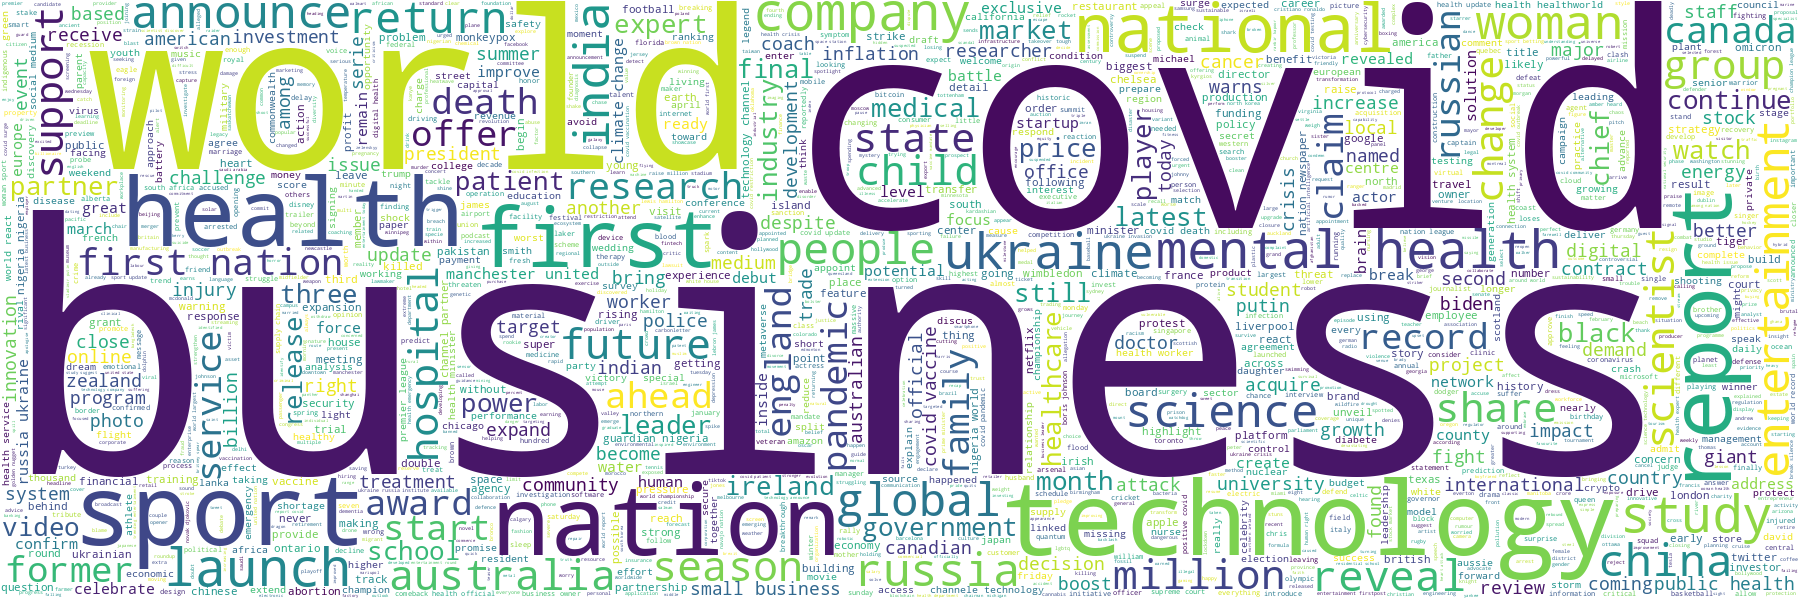

In [14]:
long_string = ','.join(all_text_tokens)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='steelblue', height=600, width=1800)
wordcloud.generate(long_string)
wordcloud.to_image()

# Latent Dirichlet Allocation (LDA) - Topic Modeling

In [23]:
id2word = corpora.Dictionary(data_wrods)
corpus = [id2word.doc2bow(text) for text in data_wrods]
data_wrods[:1][0], corpus[:1][0]

(['business', 'longview', 'business'], [(0, 2), (1, 1)])

In [16]:
num_topics = 10
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.044*"covid" + 0.011*"world" + 0.011*"health" + 0.009*"vaccine" + '
  '0.008*"record" + 0.008*"death" + 0.008*"update" + 0.008*"report" + '
  '0.007*"canada" + 0.006*"market"'),
 (1,
  '0.026*"sport" + 0.017*"technology" + 0.012*"nation" + 0.011*"world" + '
  '0.009*"woman" + 0.009*"business" + 0.008*"update" + 0.007*"partner" + '
  '0.005*"australia" + 0.005*"transfer"'),
 (2,
  '0.017*"business" + 0.009*"report" + 0.009*"health" + 0.006*"nation" + '
  '0.005*"world" + 0.005*"covid" + 0.005*"ukraine" + 0.005*"england" + '
  '0.005*"people" + 0.005*"emergency"'),
 (3,
  '0.060*"health" + 0.016*"mental" + 0.009*"award" + 0.009*"national" + '
  '0.008*"sport" + 0.008*"million" + 0.008*"school" + 0.006*"world" + '
  '0.006*"support" + 0.006*"science"'),
 (4,
  '0.026*"world" + 0.025*"health" + 0.014*"covid" + 0.010*"nation" + '
  '0.009*"first" + 0.006*"expert" + 0.005*"ireland" + 0.005*"monkeypox" + '
  '0.005*"ukraine" + 0.004*"medical"'),
 (5,
  '0.010*"nigeria" + 0.008*"techn

In [17]:
pyLDAvis.enable_notebook()
lda_visualization = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(lda_visualization, os.path.join(lda_results_path, 'lda_visualization_'+ str(num_topics) +'.html'))
lda_visualization

/home/uzair/miniconda3/envs/news-analysis/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.136740 -0.102629       1        1  11.770410
1      0.017496  0.014502       2        1  11.300046
0     -0.035341  0.032388       3        1  11.040010
4     -0.048144 -0.027733       4        1  10.440333
8      0.201078 -0.103823       5        1  10.023515
5      0.015099 -0.033457       6        1   9.366349
7     -0.055622  0.121176       7        1   9.353323
6     -0.043032 -0.087207       8        1   9.081748
9      0.086060  0.115640       9        1   8.854410
2     -0.000854  0.071144      10        1   8.769855, topic_info=          Term         Freq        Total Category  logprob  loglift
274     health  7300.000000  7300.000000  Default  30.0000  30.0000
49       covid  4741.000000  4741.000000  Default  29.0000  29.0000
0     business  3126.000000  3126.000000  Default  28.0000  28.0000
1314    mental  1160.000000  1160.000000  Default  27.0000  27.0000
59       sport  2905.000000  2905.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
196      world   216.568749  3781.140262  Topic10  -5.2318  -0.4260
267      first   181.656090  2227.412717  Topic10  -5.4076  -0.0726
49       covid   212.901311  4741.251506  Topic10  -5.2489  -0.6694
190   minister   122.735427   656.405654  Topic10  -5.7997   0.7571
264      chief   114.964318   693.939050  Topic10  -5.8651   0.6361

[841 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
11491      5  0.974793       aamir
8881       6  0.968657    abhishek
7886       3  0.964013  aboriginal
7611       1  0.135580    abortion
7611       2  0.035889    abortion
...      ...       ...         ...
1656       6  0.091239     zealand
1656       8  0.004802     zealand
1656       9  0.069630     zealand
1656      10  0.108046     zealand
14039      8  0.953587    zimbabwe

[2985 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 5, 9, 6, 8, 7, 10, 3])